# Task IV: Quantum Generative Neural Network (QGAN)
### Task objectives:
- Apply a QGAN network on Delphes example set. The set contains 100 training and 100 testing samples, labeled as signal (1) and background (0)

### Approach:
The provided data sample in itself is quite simple. Matter of fact, a simple deep neural network (DNN) can achieve an AUC(ROC) of up to 99%. But in real world scenarios, lack of statistics can indeed be a limiting factor when considering complex datasets.

In this notebook, both a classical GAN (CGAN) and and a Quantum GAN (QGAN) are implemented, tested through the same approch:
1. The data is first investigated and normalized using min-max normalization
2. An agnostic GAN model is built, which can be used for both CGAN and QGAN
3. The GAN consist of one classical discriminator and two generators (classical/quantum) which are tuned to fake signal and background seperately
4. The network is trained and a generator is extracted
5. Using the two generators, a new, larger dataset can be generated to train a simple DNN
6. The DNN, trained on generated dataset is further assessed using a ROC curve, ROC AUC, confusion matrix and prediction distribution, evaluated on the original test set

Therefore, the target is to gauage how good are the generators themselves.

### Layout:
- Section 1: Data investigation and preperation
- Section 2: Agnostic GAN mode, simple MLP (DNN) are built and a CGAN is evaluated
- Section 3: A QGAN is built and evaluated
- Section 4: Summary

Resources used in making this notebook:
[[1]](https://keras.io/examples/generative/dcgan_overriding_train_step/)
[[2]](https://pennylane.ai/qml/demos/tutorial_QGAN)
[[3]](https://pennylane.ai/qml/demos/tutorial_quantum_gans)

**Note**: Please adjust the path to the training and testing files before running the notebook

In [ ]:
import numpy as np
import pennylane as qml
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import random

pd.options.mode.chained_assignment = None  # default='warn'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

training_file = '/PATH/TO/training_input.npy'
testing_file = '/PATH/TO/test_input.npy'

2025-04-08 00:05:57.812726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 00:05:57.823354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744063557.835821 1374319 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744063557.839803 1374319 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744063557.849955 1374319 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Section 1: Data investigation and preperation

In [2]:
# load and tag the data with appropiate labels in a pandas dataframe
temp = np.load(training_file, allow_pickle=True)
test_set = np.load(testing_file, allow_pickle=True)

train_bkg = pd.DataFrame(temp.item()['0'],columns=['feature_0','feature_1','feature_2','feature_3','feature_4'])
train_bkg['set'] = 'train'
train_bkg['bkg'] = 1
train_signal = pd.DataFrame(temp.item()['1'],columns=['feature_0','feature_1','feature_2','feature_3','feature_4'])
train_signal['set'] = 'train'
train_signal['sig'] = 1

test_bkg = pd.DataFrame(test_set.item()['0'],columns=['feature_0','feature_1','feature_2','feature_3','feature_4'])
test_bkg['set'] = 'test'
test_bkg['bkg'] = 1
test_signal = pd.DataFrame(test_set.item()['1'],columns=['feature_0','feature_1','feature_2','feature_3','feature_4'])
test_signal['set'] = 'test'
test_signal['sig'] = 1

# add fake columns. They are all zeros since they are not generated data
df = pd.concat([train_signal, train_bkg, test_signal, test_bkg], axis=0)
df = df.replace(np.nan,0)
df['fake_sig'] = 0.0
df['fake_bkg'] = 0.0

# randomize the order of the data. This is useful in making the validation set and in making the training batched. Although, in our case, due to the data small size, we will train on a batch size of 1.
df = df.sample(frac=1).reset_index(drop=True)
df

,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg,fake_sig,fake_bkg
0,0.341165,0.565224,0.930318,-0.915654,-0.595576,train,0.0,1.0,0.0,0.0
1,-0.425853,0.867645,-0.927563,-0.320383,-0.505551,train,1.0,0.0,0.0,0.0
2,0.882965,-0.954815,-0.662706,-0.784211,-0.611790,train,1.0,0.0,0.0,0.0
3,-0.999540,-0.999708,0.077700,-0.865043,-0.590197,test,0.0,1.0,0.0,0.0
4,-0.998703,-0.999125,0.077155,-0.772134,-0.561202,test,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
195,0.916722,-0.925215,-0.676579,-0.718358,-0.602142,test,1.0,0.0,0.0,0.0
196,-0.430306,0.866712,-0.925394,-0.822855,-0.169384,train,1.0,0.0,0.0,0.0
197,-0.999025,-0.999356,0.077345,-0.802860,-0.610411,train,0.0,1.0,0.0,0.0
198,-0.432738,0.861264,-0.922431,-0.888605,-0.604215,test,0.0,1.0,0.0,0.0


In [3]:
# Apply a simple min-max normalization to the input features
# A z-score normalization is available but commented. With some manual check ups, it looks like min-max is more approperiate
# as it provides better seperation in feature 4
for feature in ['feature_0','feature_1','feature_2','feature_3','feature_4']:
    #df.loc[df.sig == 0, feature] = (df.loc[df.sig == 0, feature]-df.loc[df.sig == 0, feature].mean())/df.loc[df.sig == 0, feature].std()
    #df.loc[df.sig == 1, feature] = (df.loc[df.sig == 1, feature]-df.loc[df.sig == 1, feature].mean())/df.loc[df.sig == 1, feature].std()
    df.loc[df.sig == 0, feature] = (df.loc[df.sig == 0, feature]-df.loc[df.sig == 0, feature].min())/(df.loc[df.sig == 0, feature].max()-df.loc[df.sig == 0, feature].min())
    df.loc[df.sig == 1, feature] = (df.loc[df.sig == 1, feature]-df.loc[df.sig == 1, feature].min())/(df.loc[df.sig == 1, feature].max()-df.loc[df.sig == 1, feature].min())
df

,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg,fake_sig,fake_bkg
0,0.698761,0.832190,0.997769,0.015566,0.112787,train,0.0,1.0,0.0,0.0
1,0.296575,0.987893,0.006089,0.554418,0.480707,train,1.0,0.0,0.0,0.0
2,0.973709,0.023559,0.147495,0.120261,0.329907,train,1.0,0.0,0.0,0.0
3,0.000196,0.000118,0.541252,0.072540,0.116844,test,0.0,1.0,0.0,0.0
4,0.000204,0.000112,0.542502,0.131566,0.401714,test,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
195,0.991173,0.039221,0.140088,0.181901,0.343602,test,1.0,0.0,0.0,0.0
196,0.294271,0.987400,0.007247,0.084090,0.957875,train,1.0,0.0,0.0,0.0
197,0.000464,0.000305,0.541062,0.142541,0.101597,train,0.0,1.0,0.0,0.0
198,0.295524,0.989594,0.005753,0.046016,0.106270,test,0.0,1.0,0.0,0.0


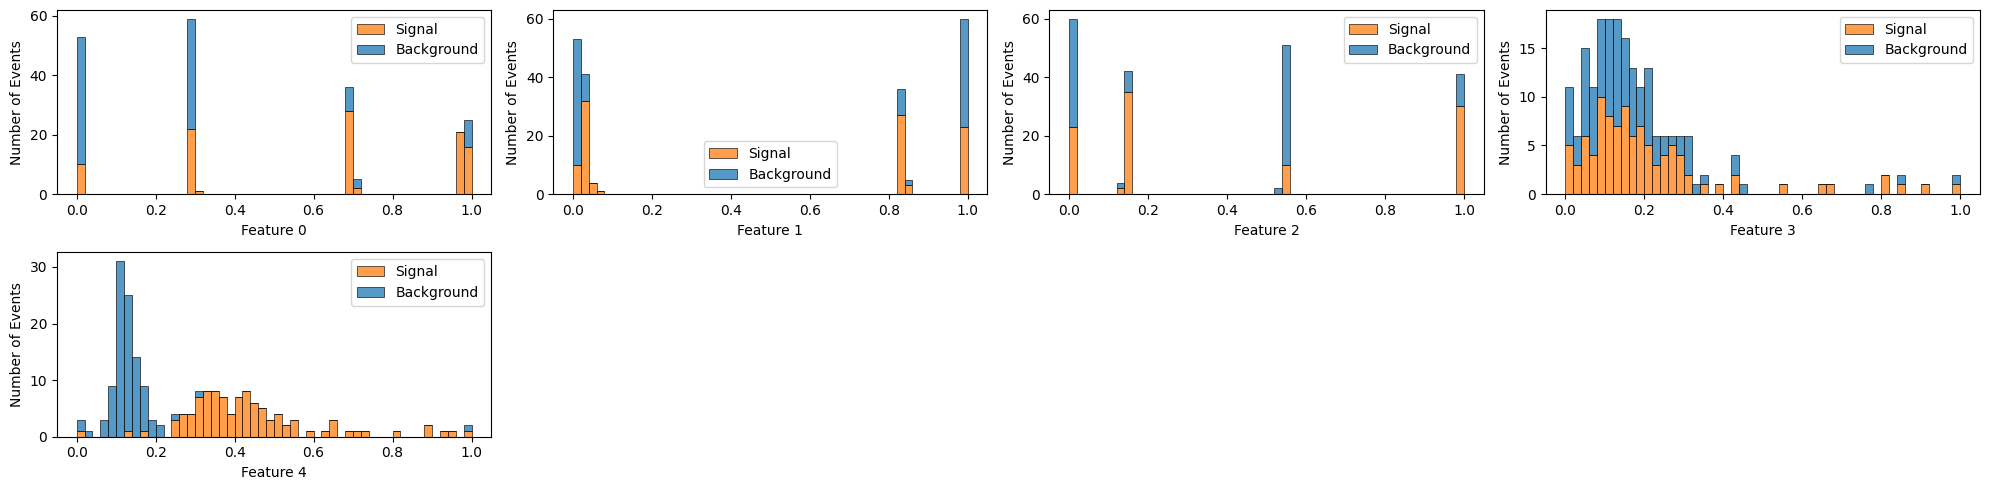

In [4]:
# The following are the histograms of each event feature
fig, ax = plt.subplots(2,4,figsize=(20,5))

tax = ax[0,0]
sns.histplot(df, x='feature_0', hue='sig', multiple='stack', bins=50, ax=tax)
tax.legend(['Signal','Background'])
tax.set_xlabel('Feature 0')
tax.set_ylabel('Number of Events')

tax = ax[0,1]
sns.histplot(df, x='feature_1', hue='sig', multiple='stack', bins=50, ax=tax)
tax.legend(['Signal','Background'])
tax.set_xlabel('Feature 1')
tax.set_ylabel('Number of Events')

tax = ax[0,2]
sns.histplot(df, x='feature_2', hue='sig', multiple='stack', bins=50, ax=tax)
tax.legend(['Signal','Background'])
tax.set_xlabel('Feature 2')
tax.set_ylabel('Number of Events')

tax = ax[0,3]
sns.histplot(df, x='feature_3', hue='sig', multiple='stack', bins=50, ax=tax)
tax.legend(['Signal','Background'])
tax.set_xlabel('Feature 3')
tax.set_ylabel('Number of Events')

tax = ax[1,0]
sns.histplot(df, x='feature_4', hue='sig', multiple='stack', bins=50, ax=tax)
tax.legend(['Signal','Background'])
tax.set_xlabel('Feature 4')
tax.set_ylabel('Number of Events')

for i in range(1,4):
    ax[1,i].xaxis.set_visible(False)
    ax[1,i].yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
       ax[1,i].spines[spine].set_visible(False)

fig.tight_layout()

## Section 2: Classical GAN Model

In [5]:
# The following provides a simple and useful MLP model
# this will later be used as a discriminator or a stand alone DNN
# a dropout layer is always placed between each dense layer
# and a gaussian noise can be added if needed as the first layer
# in the network
class MLP(tf.keras.Model):
    def __init__(self, dense_layers, activations,apply_gaussian=False, **kwargs):
        super().__init__(**kwargs)
        self.layers_ = []
        if apply_gaussian: self.layers_ += [tf.keras.layers.GaussianNoise(0.5, name='gaussian_noise_0')]
        for i in range(len(dense_layers)):
            self.layers_ += [tf.keras.layers.Dense(dense_layers[i], activation=activations[i], name='dense_' + str(i))]
            if i<len(dense_layers)-1: 
                self.layers_ += [tf.keras.layers.Dropout(0.2, name='dropout_' + str(i))]
    def call(self, inputs):
        x = inputs
        for i in range(len(self.layers_)):
            x = self.layers_[i](x)
        return x

# The following is an agnostic GAN layer, with two generators and one discriminator
# the dimensionality of the latent space can be controlled as needed. If -1, the latent space
# will match the the length of the input features
class GAN(tf.keras.Model):
    def __init__(self, signal_generator, background_generator, discriminator, latent_dim=-1, **kwargs):
        super().__init__(**kwargs)
        self.signal_generator = signal_generator
        self.background_generator = background_generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    # set all of the GAN models, losses and optimizers
    def compile(self, discriminator_optimizer, signal_generator_optimizer, background_generator_optimizer,
                discremenator_loss, signal_generator_loss, background_generator_loss, 
                **kwargs):
        super().compile(**kwargs)
        self.discriminator_optimizer = discriminator_optimizer
        self.signal_generator_optimizer = signal_generator_optimizer
        self.background_generator_optimizer = background_generator_optimizer
        
        self.discremenator_loss = discremenator_loss
        self.signal_generator_loss = signal_generator_loss
        self.background_generator_loss = background_generator_loss
    
    # this function will be used to generate the random latent space 
    # with the approperiate dimensions
    def noise_generator(self, batch_size, features_shape):
        if self.latent_dim == -1:
            signal_noise = tf.random.normal(shape=(batch_size, features_shape))
            background_noise = tf.random.normal(shape=(batch_size, features_shape))
        else:
            signal_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
            background_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        return signal_noise, background_noise
    
    # training updates
    def train_step(self, inputs):
        real_data = inputs[0]
        real_classes = tf.cast(inputs[1],dtype=tf.float32)
        batch_size = tf.shape(real_data)[0]
        features_shape = tf.shape(real_data)[-1]

        # initiate all truth level labels individually. This is to be used in the losses later on
        signal_classes = tf.repeat(tf.constant([[1,0,0,0]]), [batch_size], axis=0)
        background_classes = tf.repeat(tf.constant([[0,1,0,0]]), [batch_size], axis=0)
        fake_signal_classes = tf.repeat(tf.constant([[0,0,1,0]]), [batch_size], axis=0)
        fake_background_classes = tf.repeat(tf.constant([[0,0,0,1]]), [batch_size], axis=0)

        # Train the discriminator over fake+real and update its gradient using 
        # the discriminator loss on both fake+real
        signal_noise, background_noise = self.noise_generator(batch_size, features_shape)
        with tf.GradientTape() as tape:
            generated_signal = self.signal_generator(signal_noise, training=False)
            generated_background = self.background_generator(background_noise, training=False)

            real_output = self.discriminator(real_data, training=True)
            fake_signal_output = self.discriminator(generated_signal, training=True)
            fake_background_output = self.discriminator(generated_background, training=True)
            disc_loss = self.discremenator_loss(real_classes, real_output) +\
                        self.discremenator_loss(fake_signal_classes, fake_signal_output) +\
                        self.discremenator_loss(fake_background_classes, fake_background_output)
            
        grads = tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        
        # Train the signal generator the latent space and update its gradient using 
        # the signal generator loss
        signal_noise, background_noise = self.noise_generator(batch_size, features_shape)
        with tf.GradientTape() as tape:
            generated_signal = self.signal_generator(signal_noise, training=True)
            generated_background = self.background_generator(background_noise, training=False)

            fake_signal_output = self.discriminator(generated_signal, training=False)
            sig_gen_loss = self.signal_generator_loss(signal_classes, fake_signal_output)
            
        grads = tape.gradient(sig_gen_loss, self.signal_generator.trainable_variables)
        self.signal_generator_optimizer.apply_gradients(zip(grads, self.signal_generator.trainable_variables))
        
        # Train the background generator the latent space and update its gradient using 
        # the generator generator loss
        signal_noise, background_noise = self.noise_generator(batch_size, features_shape)
        with tf.GradientTape() as tape:
            generated_signal = self.signal_generator(signal_noise, training=False)
            generated_background = self.background_generator(background_noise, training=True)
            fake_background_output = self.discriminator(generated_background, training=False)

            bkg_gen_loss = self.background_generator_loss(background_classes, fake_background_output)
            
        grads = tape.gradient(bkg_gen_loss, self.background_generator.trainable_variables)
        self.background_generator_optimizer.apply_gradients(zip(grads, self.background_generator.trainable_variables))

        return {"sig_gen_loss": sig_gen_loss, "bkg_gen_loss": bkg_gen_loss,"disc_loss": disc_loss}

In [6]:
# Descriminator Network
classical_discriminator = MLP((64,32,16,4),('relu','relu','relu','softmax'), apply_gaussian=True, name= 'classical_discriminator')

# Classical Generators
classical_signal_generator = MLP((64,32,16,5),('relu','relu','relu','linear'), name = 'classical_signal_generator')
classical_background_generator = MLP((64,32,16,5),('relu','relu','relu','linear'), name = 'classical_background_generator')

# Classical GAN Model
classical_GAN = GAN(classical_signal_generator, classical_background_generator, classical_discriminator, latent_dim=5, name="classical_GAN")

classical_GAN.compile(
    discriminator_optimizer=tf.keras.optimizers.RMSprop(0.001),
    signal_generator_optimizer=tf.keras.optimizers.RMSprop(0.001),
    background_generator_optimizer=tf.keras.optimizers.RMSprop(0.001),

    discremenator_loss=tf.keras.losses.CategoricalCrossentropy(name='disc_loss'),
    signal_generator_loss=tf.keras.losses.CategoricalCrossentropy(name='sig_gen_loss'),
    background_generator_loss=tf.keras.losses.CategoricalCrossentropy(name='bkg_gen_loss')
)

W0000 00:00:1744063560.934787 1374319 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
history_classical_GAN = classical_GAN.fit(df[df.set!='test'][df.columns[:5]].values,
                                            df[df.set!='test'][df.columns[6:]].values,
                                            batch_size=100,
                                            epochs=2000,
                                            verbose=0
                                            )

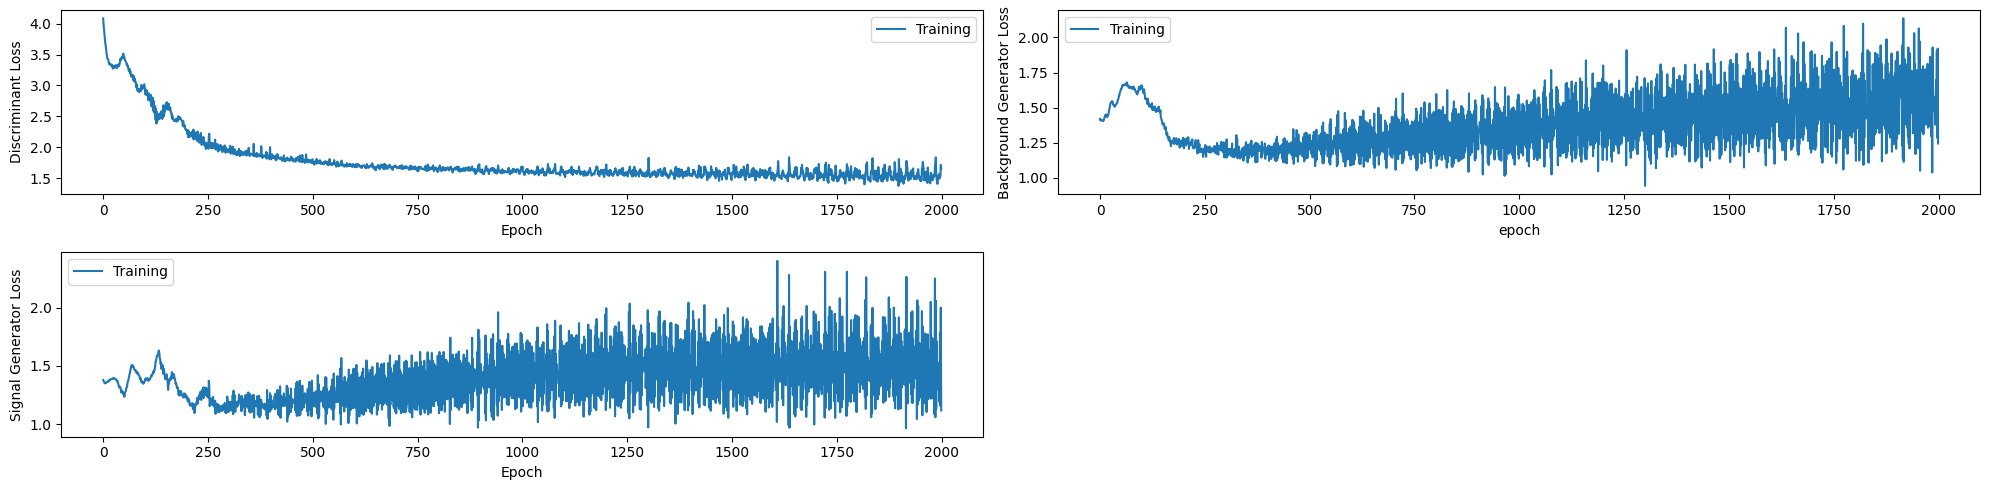

In [8]:
# The following plots visualize the training loss of the both generators and the discriminator
# it appears that the generators are having a hard time adjusting the feature space
# the discriminator in the other hand seem to saturate at around 1000 epochs, meaning that
# the gnerators have stopped making progress and the discriminator has learned the fake and 
# real events quite well
fig, ax = plt.subplots(2,2,figsize=(20,5))

sns.lineplot(x='epoch', y='disc_loss', data={'disc_loss': history_classical_GAN.history['disc_loss'], 'epoch': history_classical_GAN.epoch}, label="Training", ax=ax[0,0])
ax[0,0].set_ylabel('Discriminant Loss')
ax[0,0].set_xlabel('Epoch')

sns.lineplot(x='epoch', y='sig_gen_loss', data={'sig_gen_loss': history_classical_GAN.history['sig_gen_loss'], 'epoch': history_classical_GAN.epoch}, label="Training", ax=ax[1,0])
ax[1,0].set_ylabel('Signal Generator Loss')
ax[1,0].set_xlabel('Epoch')

sns.lineplot(x='epoch', y='bkg_gen_loss', data={'bkg_gen_loss': history_classical_GAN.history['bkg_gen_loss'], 'epoch': history_classical_GAN.epoch}, label="Training", ax=ax[0,1])
ax[0,1].set_ylabel('Background Generator Loss')
ax[1,0].set_xlabel('Epoch')

ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
for spine in ['top', 'right', 'left', 'bottom']:
    ax[1,1].spines[spine].set_visible(False)

fig.tight_layout()

In [9]:
# Now, I will make a dataframe that has both real test data and generated data
# both datasets will be passed by the generator to see it's behavior

# Firs, predict on the test set
df_pred = df[df.set=='test']
prediction = classical_GAN.discriminator.predict(df[df.set=='test'][df.columns[:5]].values)
df_pred[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']] = prediction
df_pred

# Second, generate signal and background 50+50 and then pass them to the discriminator for prediction
# only 100 are generated to make it easier to compare with the test set, which has 100 events
N = 50
random_var = tf.random.normal(shape=(N,5))
sig_gen = classical_GAN.signal_generator(random_var)
sig_gen = tf.concat([sig_gen, np.repeat([[0,0,1,0]],N,axis=0)],-1)

random_var = tf.random.normal(shape=(N,5))
bkg_gen = classical_GAN.background_generator(random_var)
bkg_gen = tf.concat([bkg_gen, np.repeat([[0,0,0,1]],N,axis=0)],-1)

df_gen = pd.DataFrame(np.concatenate([sig_gen,bkg_gen]),columns=['feature_0','feature_1','feature_2','feature_3','feature_4','sig','bkg','fake_sig','fake_bkg'])
df_gen.insert(5, 'set', np.array(['sigFake']*N+['bkgFake']*N)[:,None])

# Now, predict on the generated set
prediction = classical_GAN.discriminator.predict(df_gen[df_gen.columns[:5]].values)
df_gen[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']] = prediction
df_gen

# Finally, combine test and generated dataset in one dataframe
df_pred = pd.concat([df_pred,df_gen], axis=0)
df_pred['process'] = 0*df_pred['sig']+ 1*df_pred['bkg'] + 2*df_pred['fake_sig']+ 3*df_pred['fake_bkg']
df_pred.reset_index(drop=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg,fake_sig,fake_bkg,pred_sig,pred_bkg,pred_sig_fake,pred_bkg_fake,process
0,0.000196,0.000118,0.541252,0.072540,0.116844,test,0.0,1.0,0.0,0.0,0.000019,3.885999e-01,0.000003,6.113788e-01,1.0
1,0.000204,0.000112,0.542502,0.131566,0.401714,test,1.0,0.0,0.0,0.0,0.968066,1.857768e-04,0.031723,2.532263e-05,0.0
2,0.000560,0.000333,0.542304,0.182930,0.504622,test,1.0,0.0,0.0,0.0,0.970223,4.847330e-07,0.029776,6.634594e-09,0.0
3,0.000248,0.000138,0.541227,0.075949,0.122392,test,0.0,1.0,0.0,0.0,0.000022,3.980065e-01,0.000003,6.019691e-01,1.0
4,0.297406,0.994551,0.002906,0.161277,0.111284,test,0.0,1.0,0.0,0.0,0.000045,5.691563e-01,0.000105,4.306939e-01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.307894,0.998622,0.000041,0.118600,0.164365,bkgFake,0.0,0.0,0.0,1.0,0.000251,4.908972e-01,0.000490,5.083619e-01,3.0
196,0.007564,-0.004515,0.541966,0.075754,0.146358,bkgFake,0.0,0.0,0.0,1.0,0.000032,3.551005e-01,0.000004,6.448629e-01,3.0
197,0.006845,-0.007477,0.554922,0.161841,0.092661,bkgFake,0.0,0.0,0.0,1.0,0.000011,3.198572e-01,0.000002,6.801304e-01,3.0
198,0.326557,1.041139,-0.015200,0.116762,0.140626,bkgFake,0.0,0.0,0.0,1.0,0.000029,2.266914e-01,0.000139,7.731410e-01,3.0


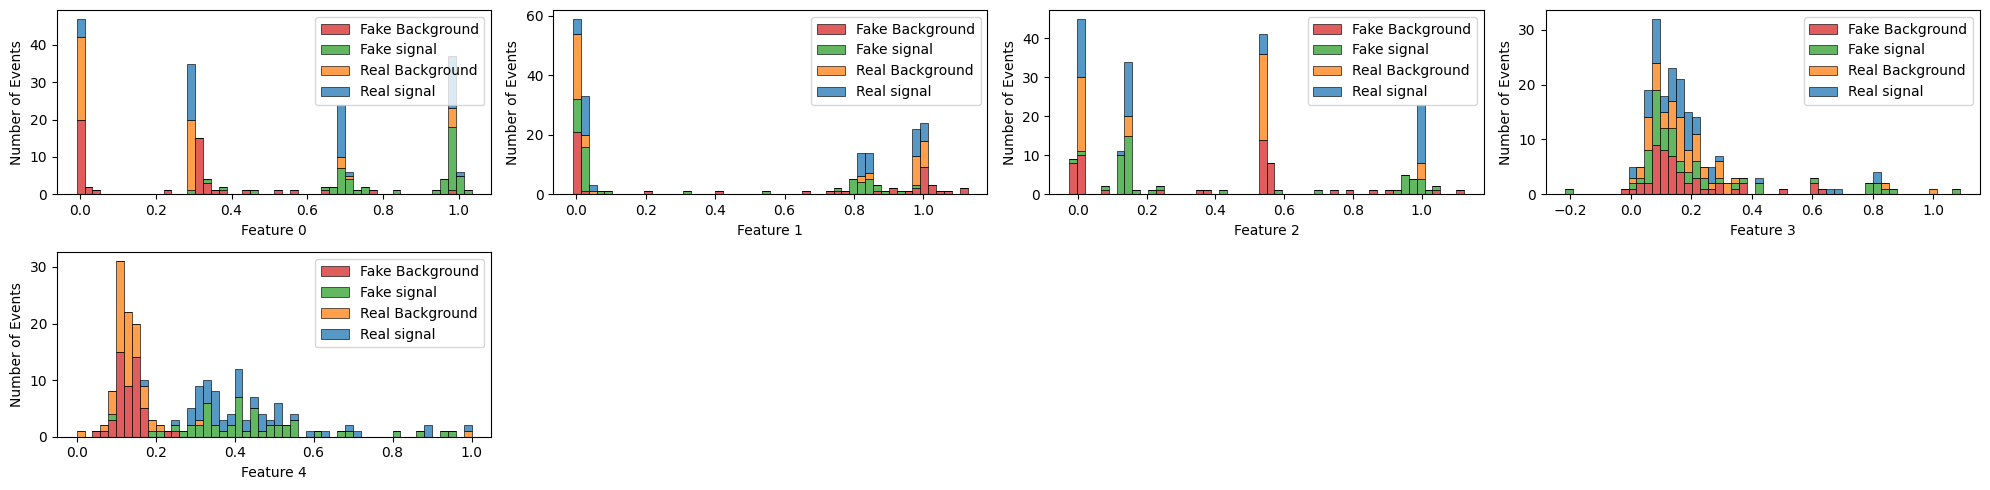

In [10]:
# The following is a comparison between the generated dataset and the test set distributions.
# It is clear that the generators are doing a good job in following the test set distributions in feature 3 and 4,
# but they lack the modeling power in feature 0-2 where the distribution is more sparse/discrete
fig, ax = plt.subplots(2,4,figsize=(20,5))

color_palette = sns.color_palette()[:4]
legend = ['Fake Background', 'Fake signal', 'Real Background', 'Real signal']

tax = ax[0,0]
sns.histplot(df_pred, x='feature_0', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 0')
tax.set_ylabel('Number of Events')

tax = ax[0,1]
sns.histplot(df_pred, x='feature_1', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 1')
tax.set_ylabel('Number of Events')

tax = ax[0,2]
sns.histplot(df_pred, x='feature_2', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 2')
tax.set_ylabel('Number of Events')

tax = ax[0,3]
sns.histplot(df_pred, x='feature_3', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 3')
tax.set_ylabel('Number of Events')

tax = ax[1,0]
sns.histplot(df_pred, x='feature_4', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 4')
tax.set_ylabel('Number of Events')

for i in range(1,4):
    ax[1,i].xaxis.set_visible(False)
    ax[1,i].yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
       ax[1,i].spines[spine].set_visible(False)

fig.tight_layout()

Text(0.5, 23.52222222222222, 'Prediction')

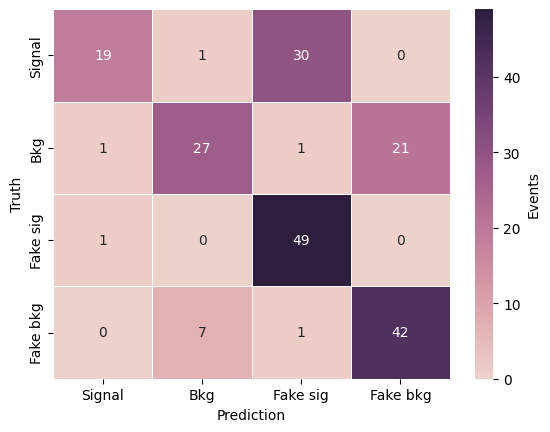

In [11]:
# Here I inspect the confusion matrix of the discriminator
# It is easy to observe that the discriminator is confusing real data with fake ones strongly
# but the other way around shows a weaker behavior
truth, pred = df_pred.process.values, df_pred[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']].values.argmax(axis=1)

matrix = sk.metrics.confusion_matrix(truth,pred)

fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), linewidths=.5, cbar_kws={'label':'Events'}, ax=ax)
ax.set_yticklabels(['Signal','Bkg','Fake sig', 'Fake bkg'])
ax.set_xticklabels(['Signal','Bkg','Fake sig', 'Fake bkg'])
ax.set_ylabel('Truth')
ax.set_xlabel('Prediction')

In [12]:
# Now, I will generate a total of 10 events, 5k signal and 5k background events
# These are to be used to train a simple DNN to improve the statistical modeling

N = 5000

random_var = tf.random.normal(shape=(N,5))
sig_gen = classical_GAN.signal_generator(random_var)
sig_gen = tf.concat([sig_gen, np.repeat([[1,0]],N,axis=0)],-1)

random_var = tf.random.normal(shape=(N,5))
bkg_gen = classical_GAN.background_generator(random_var)
bkg_gen = tf.concat([bkg_gen, np.repeat([[0,1]],N,axis=0)],-1)

df_gen = pd.DataFrame(np.concatenate([sig_gen,bkg_gen]),columns=['feature_0','feature_1','feature_2','feature_3','feature_4','sig','bkg'])
df_gen.insert(5, 'set', np.array(['sigFake']*N+['bkgFake']*N)[:,None])
df_gen = df_gen.sample(frac=1).reset_index(drop=True)


# Now, I build a simple DNN
DNN = MLP((32,16,2),('relu','relu','softmax'), name= 'DNN')
DNN.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.BinaryCrossentropy()
)

# The dataset is split to training and validation sets
df_gen_train, df_gen_validate = df_gen[:N], df_gen[N:]
df_gen_train # a glimbse on the trianing set

,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg
0,0.716921,0.849519,0.986221,0.077082,0.458074,sigFake,1.0,0.0
1,0.018710,-0.018011,0.546478,0.099394,0.120801,bkgFake,0.0,1.0
2,0.518928,0.605886,0.069376,0.258198,1.056515,sigFake,1.0,0.0
3,0.989462,0.015266,0.153982,0.139975,0.489459,sigFake,1.0,0.0
4,0.971563,0.040602,0.158561,0.648104,0.106203,sigFake,1.0,0.0
...,...,...,...,...,...,...,...,...
4995,0.971232,0.009105,0.148890,0.108199,0.438089,sigFake,1.0,0.0
4996,0.963462,-0.001072,0.129946,0.051425,0.403595,sigFake,1.0,0.0
4997,0.663430,0.813765,0.961158,-0.011705,0.535862,sigFake,1.0,0.0
4998,0.250398,0.828043,0.049174,0.042770,0.111689,bkgFake,0.0,1.0


In [13]:
# Now, I train the DNN
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-9),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
history_classical_DNN = DNN.fit(df_gen_train[df_gen_train.columns[:5]].values,
                                df_gen_train[df_gen_train.columns[6:8]].values,
                                batch_size=256,
                                epochs=1000,
                                validation_data=(df_gen_validate[df_gen_validate.columns[:5]].values,
                                                df_gen_validate[df_gen_validate.columns[6:8]].values),
                                callbacks=callbacks,
                                verbose=0
                                )

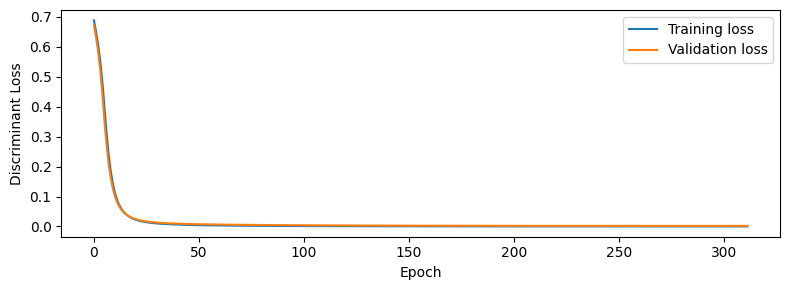

In [14]:
# visualize the DNN training
fig, ax = plt.subplots(figsize=(8,3))

sns.lineplot(x='epoch', y='loss', data={'loss': history_classical_DNN.history['loss'], 'epoch': history_classical_DNN.epoch}, label="Training loss", ax=ax)
sns.lineplot(x='epoch', y='val_loss', data={'val_loss': history_classical_DNN.history['val_loss'], 'epoch': history_classical_DNN.epoch}, label="Validation loss", ax=ax)
ax.set_ylabel('Discriminant Loss')
ax.set_xlabel('Epoch')

fig.tight_layout()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test set ROC AUC = 0.971


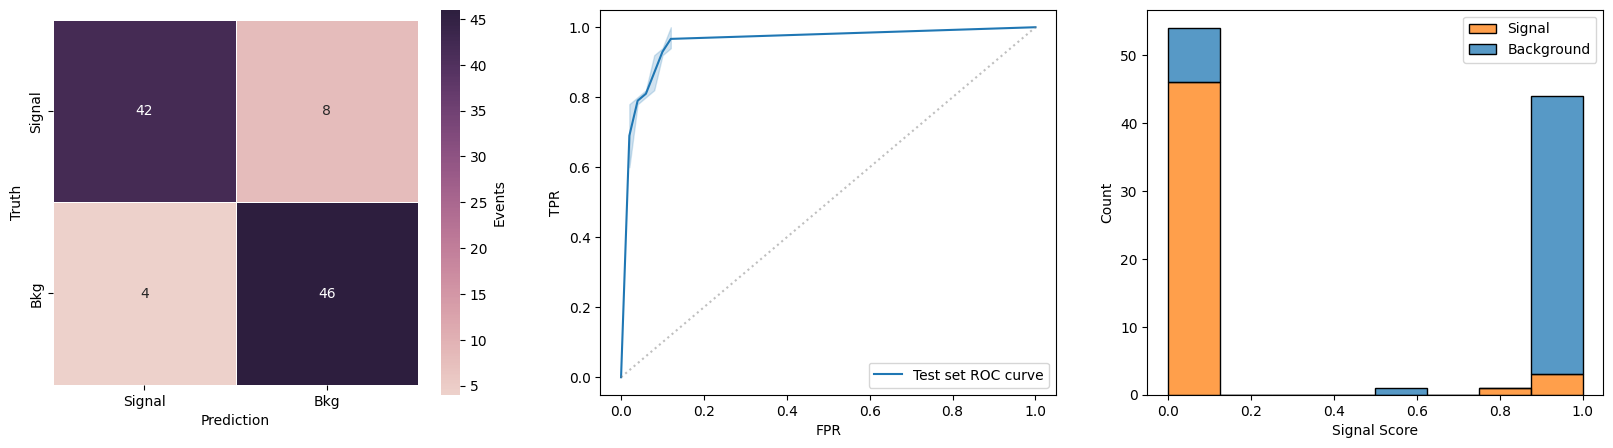

In [15]:
# predict on the test set
df_pred = df[df.set=='test']
prediction = DNN.predict(df[df.set=='test'][df.columns[:5]].values)
df_pred[['pred_sig','pred_bkg']] = prediction

# combine test prediction and generated dataset
df_pred['process'] = 0*df_pred['sig']+ 1*df_pred['bkg'] + 2*df_pred['fake_sig']+ 3*df_pred['fake_bkg']
df_pred.reset_index(drop=True)
df_pred


# The following is a visualization of the DNN output using confusion matrix, ROC curve (and AUC) as well as the signal distribution itself
truth, pred = df_pred.process.values, df_pred[['pred_sig','pred_bkg']].values.argmax(axis=1)

matrix = sk.metrics.confusion_matrix(truth,pred)
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.heatmap(matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), linewidths=.5, cbar_kws={'label':'Events'}, ax=ax[0])
ax[0].set_yticklabels(['Signal','Bkg'])
ax[0].set_xticklabels(['Signal','Bkg'])
ax[0].set_ylabel('Truth')
ax[0].set_xlabel('Prediction')
ax[0].set_aspect(1)

FPR, TPR, _ = sk.metrics.roc_curve( df_pred['sig'].tolist(),df_pred['pred_sig'].tolist() )
AUC = sk.metrics.roc_auc_score( df_pred['sig'].tolist(),df_pred['pred_sig'].tolist() )
sns.lineplot(pd.DataFrame({'TPR':TPR, 'FPR':FPR}), x='FPR', y='TPR',ax=ax[1])
ax[1].plot([0,1],[0,1],linestyle=':',color='gray',alpha=0.5)
ax[1].legend(['Test set ROC curve'])

sns.histplot(df_pred, x='pred_sig', hue='process', multiple='stack', ax=ax[2])
ax[2].legend(['Signal','Background'])
ax[2].set_xlabel('Signal Score')

print('Test set ROC AUC = %.3f' % (AUC,))

## Section 3: Quantum GAN

The network as it is shown in the next two cells takes an N number of qubits, embed them through using a noisy input using RY rotations, representing the latent space in the classical GAN model shown earlier.

Each node is then parameterized via a weighted (learnable) RY rotation, the qubit is then connected to its neighbour via a control Z gate. Achieving connectivity across all wires.

The model iself is inspired by the following articles: [Quantum GANs](https://pennylane.ai/qml/demos/tutorial_quantum_gans) and [Quantum generative adversarial networks with Cirq + TensorFlow](https://pennylane.ai/qml/demos/tutorial_QGAN)

In [99]:
# Define the quantum circuit layout
n_qubits = 5  # Total number of qubits / N
q_depth = 10  # Depth of the parameterised quantum circuit / D
dev = qml.device('default.qubit', wires=n_qubits, seed=42)

# the quantum circuit is interfaced with tensorflow

@qml.qnode(dev, diff_method="best", interface='tf')
def quantum_circuit(noise, weights, n_qubits=n_qubits, q_depth=q_depth):
    # Initialise latent vectors
    
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
    
    # return the probability of each computational basis
    return qml.probs(wires=list(range(n_qubits)))

Probabilities: tf.Tensor(
[4.11976951e-02 2.31471411e-05 1.55522060e-01 2.71383502e-02
 6.71979979e-02 3.54670734e-03 7.60444691e-02 7.69213508e-03
 5.54160346e-03 3.31760538e-02 1.24413778e-01 1.84573413e-03
 2.07775024e-04 8.57463457e-02 3.17783306e-02 5.78660597e-03
 2.53176315e-07 1.76261314e-02 4.01538482e-02 9.42265265e-03
 8.22261633e-03 4.09919599e-03 5.51374576e-03 5.88979159e-04
 2.11806812e-03 1.21417418e-02 1.98049471e-02 2.38968396e-03
 6.47204607e-02 4.93941473e-02 9.66007425e-02 3.44084254e-04], shape=(32,), dtype=float64)


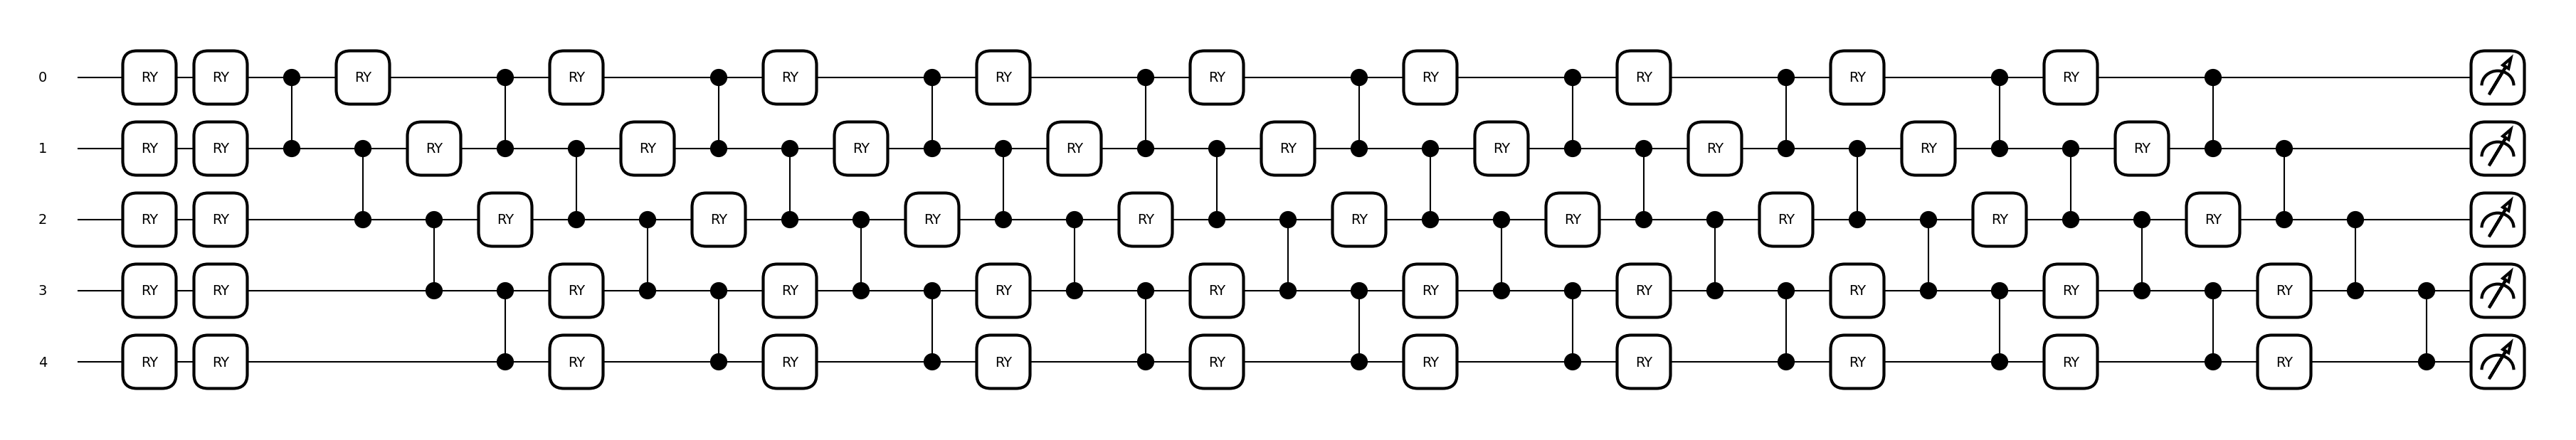

In [100]:
# visualize the quantum circuit and test the output of the circuit
inputs = tf.constant(np.random.uniform(0, np.pi, n_qubits), dtype=tf.float32)
weights = tf.Variable(np.random.uniform(0, np.pi, (q_depth, n_qubits)), dtype=tf.float32)

fig, ax = qml.draw_mpl(quantum_circuit)(inputs,weights)
print('Probabilities:', quantum_circuit(inputs,weights))

In [ ]:
# Build a quantum layer using the circuit above
class quantumLayer(tf.keras.layers.Layer):
    def __init__(self, q_depth, n_qubits, output_dim):
        super().__init__()
        self.q_depth = q_depth
        self.n_qubits = n_qubits
        self.output_dim = output_dim
        self.w = self.add_weight(
            shape=(q_depth, n_qubits),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs):
        measurement = quantum_circuit(inputs, self.w, 
                                      n_qubits=self.n_qubits, q_depth=self.q_depth)
        return measurement

# Implement a quantum generator using the prevoious quantum layer.
# In this generator, the probabilities are passed in the end to a linear dense layer
# this eases the interoperability of the quantum circuit probabilities, since they scale as 2^(n_qubits)
# The last layer ensures the output of the model is always of the same dimension regardless of the size of the quantum circuit
class quantumGenerator(tf.keras.Model):
    def __init__(self, q_depth, n_qubits, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.q_depth = q_depth
        self.n_qubits = n_qubits
        self.quantum_layer = quantumLayer(q_depth,n_qubits,output_dim)
        self.dense_output = tf.keras.layers.Dense(output_dim,activation='linear')
    
    def call(self, inputs):
        x = inputs
        x = tf.map_fn(lambda slice: tf.cast(self.quantum_layer(slice), tf.float32), x, dtype=tf.float32)
        x = self.dense_output(x)
        return x

In [104]:
# build and compile the QGAN
# Descriminator Network
classical_discriminator = MLP((16,4),('relu','softmax'), apply_gaussian=True, name= 'classical_discriminator')

# Quantum Generators
quantum_signal_generator = quantumGenerator(q_depth, n_qubits, output_dim=5, name='quantum_signal_generator')
quantum_background_generator = quantumGenerator(q_depth, n_qubits, output_dim=5, name='quantum_background_generator')

# Quantum GAN Model
quantum_GAN = GAN(quantum_signal_generator, quantum_background_generator, classical_discriminator, latent_dim=n_qubits, name="quantum_GAN")

quantum_GAN.compile(
    discriminator_optimizer=tf.keras.optimizers.RMSprop(0.001),
    signal_generator_optimizer=tf.keras.optimizers.RMSprop(0.001),
    background_generator_optimizer=tf.keras.optimizers.RMSprop(0.001),

    discremenator_loss=tf.keras.losses.CategoricalCrossentropy(name='disc_loss'),
    signal_generator_loss=tf.keras.losses.CategoricalCrossentropy(name='sig_gen_loss'),
    background_generator_loss=tf.keras.losses.CategoricalCrossentropy(name='bkg_gen_loss')
)

In [105]:
# Now the QGAN is trained similar to the classical GAN
# The complex128 warning is expected. Sadly, there is no good workaround
# https://discuss.pennylane.ai/t/error-creating-a-keras-model-with-a-quantum-circuit-as-a-layer/2911/4
# Note: the computation is expected to take a considerable amount of time
history_quantum_GAN = quantum_GAN.fit(df[df.set!='test'][df.columns[:5]].values,
                                            df[df.set!='test'][df.columns[6:]].values,
                                            batch_size=100,
                                            epochs=1500,
                                            verbose=0
                                            )

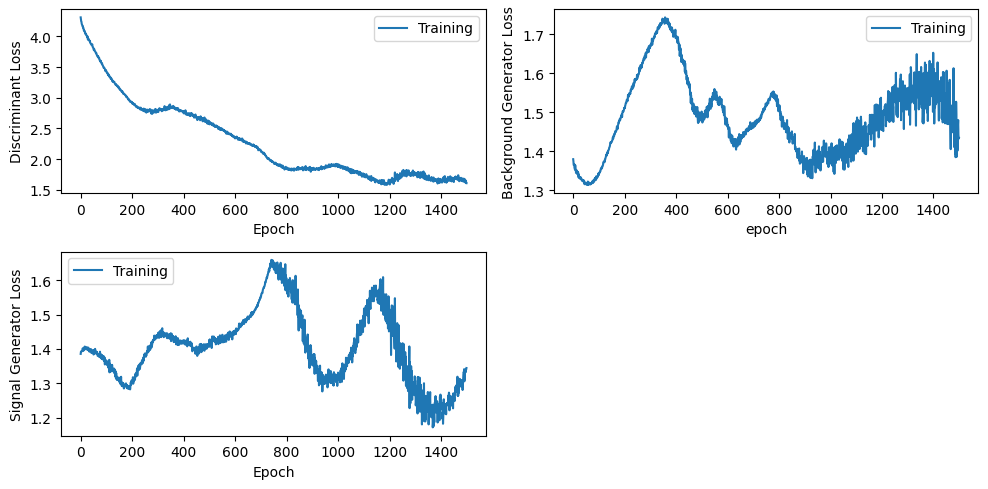

In [106]:
# The following is a visualization of the QGAN training

fig, ax = plt.subplots(2,2,figsize=(10,5))

sns.lineplot(x='epoch', y='disc_loss', data={'disc_loss': history_quantum_GAN.history['disc_loss'], 'epoch': history_quantum_GAN.epoch}, label="Training", ax=ax[0,0])
ax[0,0].set_ylabel('Discriminant Loss')
ax[0,0].set_xlabel('Epoch')

sns.lineplot(x='epoch', y='sig_gen_loss', data={'sig_gen_loss': history_quantum_GAN.history['sig_gen_loss'], 'epoch': history_quantum_GAN.epoch}, label="Training", ax=ax[1,0])
ax[1,0].set_ylabel('Signal Generator Loss')
ax[1,0].set_xlabel('Epoch')

sns.lineplot(x='epoch', y='bkg_gen_loss', data={'bkg_gen_loss': history_quantum_GAN.history['bkg_gen_loss'], 'epoch': history_quantum_GAN.epoch}, label="Training", ax=ax[0,1])
ax[0,1].set_ylabel('Background Generator Loss')
ax[1,0].set_xlabel('Epoch')

ax[1,1].xaxis.set_visible(False)
ax[1,1].yaxis.set_visible(False)
for spine in ['top', 'right', 'left', 'bottom']:
    ax[1,1].spines[spine].set_visible(False)

fig.tight_layout()

In [107]:
# similar to the classical GAN, I make a dataframe combination
# containing the test set and an equal size generated set
# these are then passed to the discriminator

# predict on the test set
df_pred = df[df.set=='test']
prediction = quantum_GAN.discriminator.predict(df[df.set=='test'][df.columns[:5]].values)
df_pred[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']] = prediction
df_pred

# generate signal and background 50+50 and then pass to discriminator for prediction
N=50
random_var = tf.random.normal(shape=(N,n_qubits))
sig_gen = quantum_GAN.signal_generator(random_var)
sig_gen = tf.concat([sig_gen, np.repeat([[0,0,1,0]],N,axis=0)],-1)

random_var = tf.random.normal(shape=(N,n_qubits))
bkg_gen = quantum_GAN.background_generator(random_var)
bkg_gen = tf.concat([bkg_gen, np.repeat([[0,0,0,1]],N,axis=0)],-1)

df_gen = pd.DataFrame(np.concatenate([sig_gen,bkg_gen]),columns=['feature_0','feature_1','feature_2','feature_3','feature_4','sig','bkg','fake_sig','fake_bkg'])
df_gen.insert(5, 'set', np.array(['sigFake']*N+['bkgFake']*N)[:,None])

# predict on the test set
prediction = quantum_GAN.discriminator.predict(df_gen[df_gen.columns[:5]].values)
df_gen[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']] = prediction
df_gen

# combine test prediction and generated dataset
df_pred = pd.concat([df_pred,df_gen], axis=0)
df_pred['process'] = 0*df_pred['sig']+ 1*df_pred['bkg'] + 2*df_pred['fake_sig']+ 3*df_pred['fake_bkg']
df_pred.reset_index(drop=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg,fake_sig,fake_bkg,pred_sig,pred_bkg,pred_sig_fake,pred_bkg_fake,process
0,0.000196,0.000118,0.541252,0.072540,0.116844,test,0.0,1.0,0.0,0.0,0.002259,0.546787,0.001338,0.449616,1.0
1,0.000204,0.000112,0.542502,0.131566,0.401714,test,1.0,0.0,0.0,0.0,0.301135,0.250030,0.279145,0.169690,0.0
2,0.000560,0.000333,0.542304,0.182930,0.504622,test,1.0,0.0,0.0,0.0,0.456373,0.033312,0.490239,0.020076,0.0
3,0.000248,0.000138,0.541227,0.075949,0.122392,test,0.0,1.0,0.0,0.0,0.002459,0.553027,0.001484,0.443030,1.0
4,0.297406,0.994551,0.002906,0.161277,0.111284,test,0.0,1.0,0.0,0.0,0.004210,0.289986,0.007409,0.698396,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.622922,0.118968,0.930777,0.053330,0.101106,bkgFake,0.0,0.0,0.0,1.0,0.014713,0.315246,0.004452,0.665589,3.0
196,0.369715,0.795030,-0.228985,-0.020762,0.133472,bkgFake,0.0,0.0,0.0,1.0,0.003439,0.250143,0.005819,0.740598,3.0
197,0.479508,0.512249,0.328556,0.167100,0.188365,bkgFake,0.0,0.0,0.0,1.0,0.017499,0.166779,0.033100,0.782622,3.0
198,0.747433,0.573301,0.640338,0.077510,0.085392,bkgFake,0.0,0.0,0.0,1.0,0.011123,0.212920,0.005141,0.770816,3.0


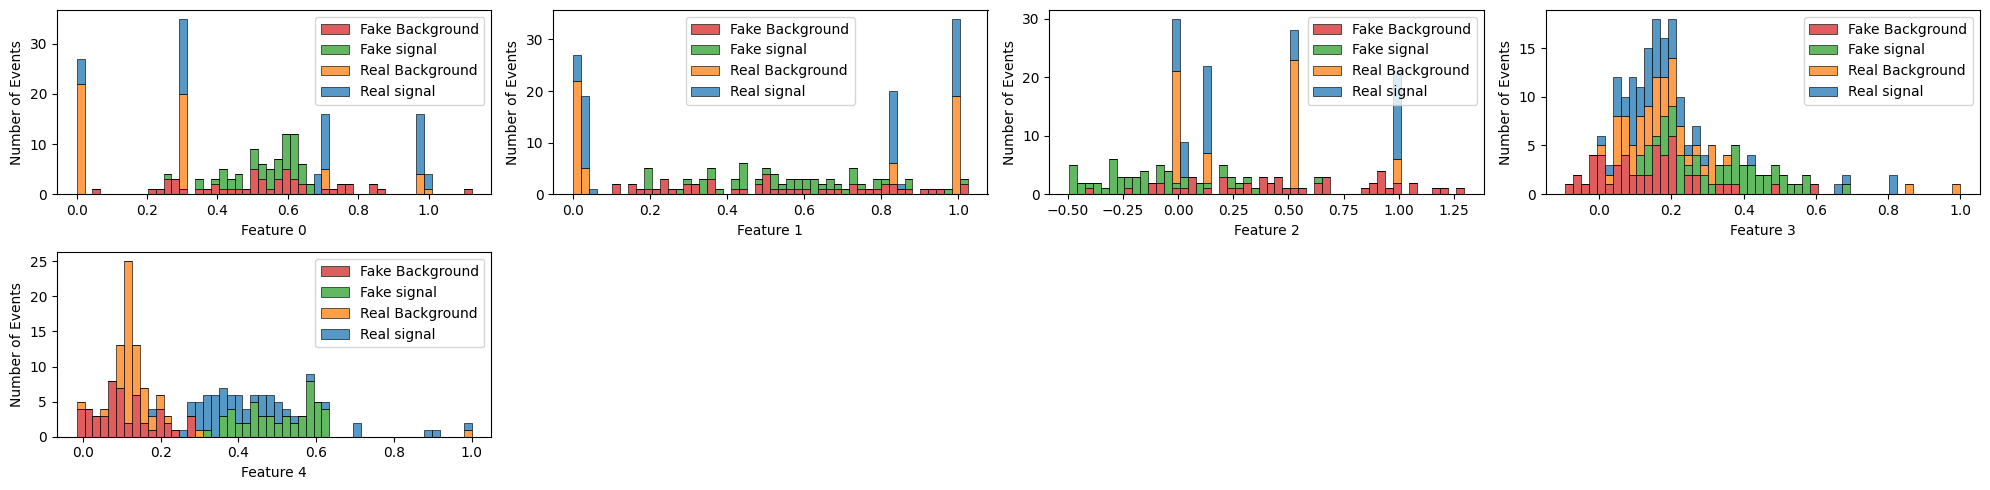

In [ ]:
# The following is the feature distribution of the test dataset and the generated dataset
# The QGAN seem to struggle more with the discrete features

fig, ax = plt.subplots(2,4,figsize=(20,5))

color_palette = sns.color_palette()[:4]
legend = ['Fake Background', 'Fake signal', 'Real Background', 'Real signal']

tax = ax[0,0]
sns.histplot(df_pred, x='feature_0', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 0')
tax.set_ylabel('Number of Events')

tax = ax[0,1]
sns.histplot(df_pred, x='feature_1', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 1')
tax.set_ylabel('Number of Events')

tax = ax[0,2]
sns.histplot(df_pred, x='feature_2', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 2')
tax.set_ylabel('Number of Events')

tax = ax[0,3]
sns.histplot(df_pred, x='feature_3', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 3')
tax.set_ylabel('Number of Events')

tax = ax[1,0]
sns.histplot(df_pred, x='feature_4', hue='process', multiple='stack', bins=50, ax=tax, palette=color_palette)
tax.legend(legend)
tax.set_xlabel('Feature 4')
tax.set_ylabel('Number of Events')

for i in range(1,4):
    ax[1,i].xaxis.set_visible(False)
    ax[1,i].yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
       ax[1,i].spines[spine].set_visible(False)

fig.tight_layout()

Text(0.5, 23.52222222222222, 'Prediction')

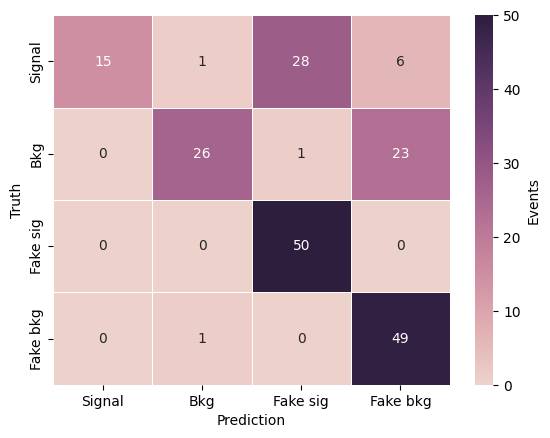

In [109]:
# similar to the classical GAN, the following is the test and generated dataset discriminator confusion matrix
# The confusion matrix itself does not look drastically different from CGAN
truth, pred = df_pred.process.values, df_pred[['pred_sig','pred_bkg','pred_sig_fake','pred_bkg_fake']].values.argmax(axis=1)

matrix = sk.metrics.confusion_matrix(truth,pred)
#
fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), linewidths=.5, cbar_kws={'label':'Events'}, ax=ax)
ax.set_yticklabels(['Signal','Bkg','Fake sig', 'Fake bkg'])
ax.set_xticklabels(['Signal','Bkg','Fake sig', 'Fake bkg'])
ax.set_ylabel('Truth')
ax.set_xlabel('Prediction')

In [110]:
# Similar to CGAN, I will generate a total of 10k events, 5k signal and 5k background events
# These are to be used to train a simple DNN to improve the statistical modeling
# Note: the computation is expected to take a considerable amount of time
N = 5000

random_var = tf.random.normal(shape=(N,5))
sig_gen = quantum_GAN.signal_generator(random_var)
sig_gen = tf.concat([sig_gen, np.repeat([[1,0]],N,axis=0)],-1)

random_var = tf.random.normal(shape=(N,5))
bkg_gen = quantum_GAN.background_generator(random_var)
bkg_gen = tf.concat([bkg_gen, np.repeat([[0,1]],N,axis=0)],-1)

df_gen = pd.DataFrame(np.concatenate([sig_gen,bkg_gen]),columns=['feature_0','feature_1','feature_2','feature_3','feature_4','sig','bkg'])
df_gen.insert(5, 'set', np.array(['sigFake']*N+['bkgFake']*N)[:,None])
df_gen = df_gen.sample(frac=1).reset_index(drop=True)


# Now, I build a simple DNN
DNN = MLP((32,16,2),('relu','relu','softmax'), name= 'DNN')
DNN.compile(
    optimizer=tf.keras.optimizers.Nadam(),
    loss=tf.keras.losses.BinaryCrossentropy()
)

# The dataset is split to training and validation sets
df_gen_train, df_gen_validate = df_gen[:N], df_gen[N:]
df_gen_train # a glimbse on the trianing set

,feature_0,feature_1,feature_2,feature_3,feature_4,set,sig,bkg
0,0.584988,0.593949,-0.028587,0.445973,0.440299,sigFake,1.0,0.0
1,0.607825,0.789881,-0.077691,0.520056,0.473481,sigFake,1.0,0.0
2,0.618227,0.362307,-0.430055,0.259252,0.615060,sigFake,1.0,0.0
3,0.567092,0.523006,-0.300883,0.317019,0.559544,sigFake,1.0,0.0
4,0.552485,0.942086,0.252089,0.594176,0.408715,sigFake,1.0,0.0
...,...,...,...,...,...,...,...,...
4995,0.550257,0.580892,-0.108341,0.409186,0.466528,sigFake,1.0,0.0
4996,0.657668,0.741826,-0.249650,0.503315,0.516232,sigFake,1.0,0.0
4997,0.561045,0.323545,-0.380720,0.183718,0.564509,sigFake,1.0,0.0
4998,0.577014,0.722466,-0.004600,0.441329,0.489821,sigFake,1.0,0.0


In [111]:
# Now, I train the DNN
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-9),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
history_classical_DNN = DNN.fit(df_gen_train[df_gen_train.columns[:5]].values,
                                df_gen_train[df_gen_train.columns[6:8]].values,
                                batch_size=256,
                                epochs=1000,
                                validation_data=(df_gen_validate[df_gen_validate.columns[:5]].values,
                                                df_gen_validate[df_gen_validate.columns[6:8]].values),
                                callbacks=callbacks,
                                verbose=0
                                )

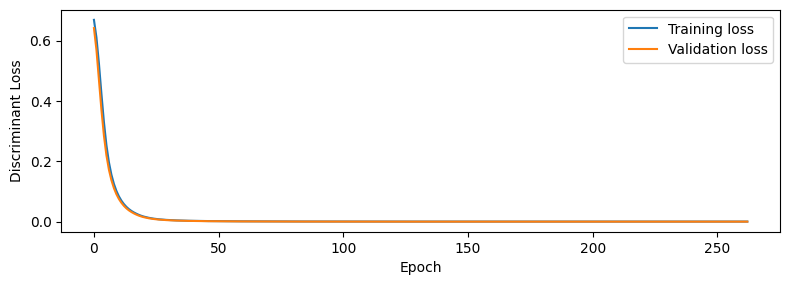

In [112]:
# visualize the DNN training
fig, ax = plt.subplots(figsize=(8,3))

sns.lineplot(x='epoch', y='loss', data={'loss': history_classical_DNN.history['loss'], 'epoch': history_classical_DNN.epoch}, label="Training loss", ax=ax)
sns.lineplot(x='epoch', y='val_loss', data={'val_loss': history_classical_DNN.history['val_loss'], 'epoch': history_classical_DNN.epoch}, label="Validation loss", ax=ax)
ax.set_ylabel('Discriminant Loss')
ax.set_xlabel('Epoch')

fig.tight_layout()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test set ROC AUC = 0.941


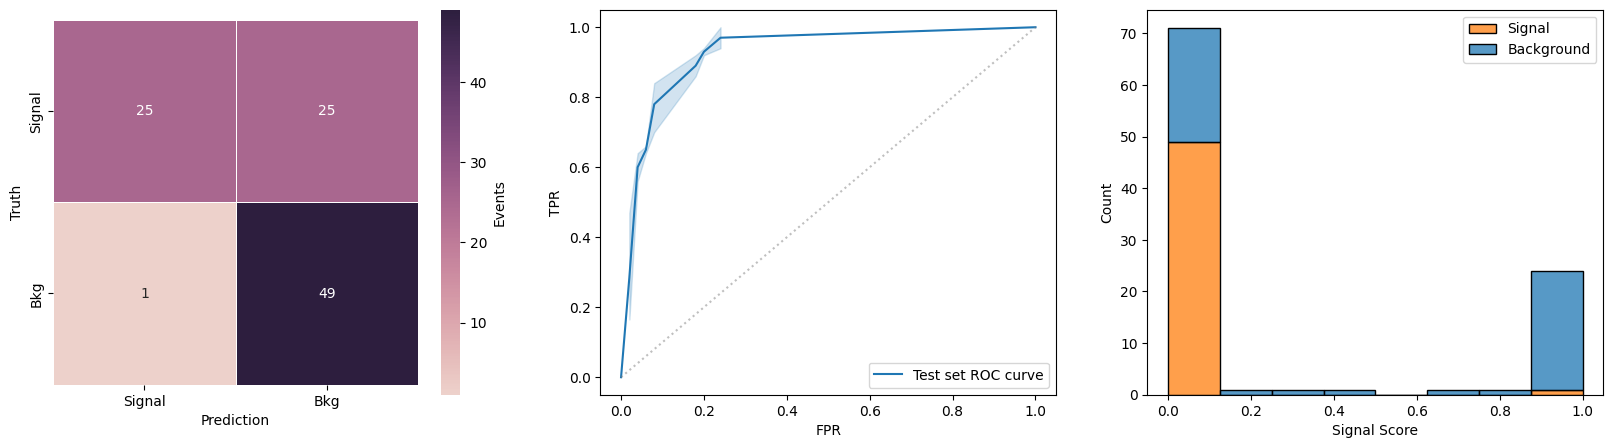

In [113]:
# predict on the test set
df_pred = df[df.set=='test']
prediction = DNN.predict(df[df.set=='test'][df.columns[:5]].values)
df_pred[['pred_sig','pred_bkg']] = prediction

# combine test prediction and generated dataset
df_pred['process'] = 0*df_pred['sig']+ 1*df_pred['bkg'] + 2*df_pred['fake_sig']+ 3*df_pred['fake_bkg']
df_pred.reset_index(drop=True)
df_pred


# The following is a visualization of the DNN output using confusion matrix, ROC curve (and AUC) as well as the signal distribution itself
truth, pred = df_pred.process.values, df_pred[['pred_sig','pred_bkg']].values.argmax(axis=1)

matrix = sk.metrics.confusion_matrix(truth,pred)
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.heatmap(matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), linewidths=.5, cbar_kws={'label':'Events'}, ax=ax[0])
ax[0].set_yticklabels(['Signal','Bkg'])
ax[0].set_xticklabels(['Signal','Bkg'])
ax[0].set_ylabel('Truth')
ax[0].set_xlabel('Prediction')
ax[0].set_aspect(1)

FPR, TPR, _ = sk.metrics.roc_curve( df_pred['sig'].tolist(),df_pred['pred_sig'].tolist() )
AUC = sk.metrics.roc_auc_score( df_pred['sig'].tolist(),df_pred['pred_sig'].tolist() )
sns.lineplot(pd.DataFrame({'TPR':TPR, 'FPR':FPR}), x='FPR', y='TPR',ax=ax[1])
ax[1].plot([0,1],[0,1],linestyle=':',color='gray',alpha=0.5)
ax[1].legend(['Test set ROC curve'])

sns.histplot(df_pred, x='pred_sig', hue='process', multiple='stack', ax=ax[2])
ax[2].legend(['Signal','Background'])
ax[2].set_xlabel('Signal Score')

print('Test set ROC AUC = %.3f' % (AUC,))

## Section 4: Summary

In the previous sections I have laid down a simple comparison between CGAN and QGAN models. The QGAN model appears to be less performant compared to the CGAN model, this might be explained by the low number of learning weights of the QGAN. Sadly, QGAN seems to be computationally heavy. Better equipments might give a more decisive answer on whether the QGAN can reach or surspass the CGAN model.

The behaviour of the training loss in both models could be attributed to the dataset in question, as it seems to be sparse and discontinues in most of its features. This plays a huge role in the training of the model. I have chosen a simple categorical cross entropy loss, which might not be optimal for the data at hand (Wasserstein loss might be useful). In the future, hyperparameter optimization could be beneficial, but in retrospect, a deeper understanding of the input feature space could be of a greater role.

When it comes to the QGAN model, a larger degree of freedom exists in tuning the model, one can for example implement a `qml.Rot` embeding instead of `RY`. The probalamtic part in the previous QGAN test is the runtime of the training. Sadly, it seems that the pennylane tensorflow interface is not that optimal.